
Unidades Produzidas por Modelo:
   Modelo  Unidades Produzidas
0  Actros                   13
1    Axor                   12
2   Arocs                   10
3   Atego                   10

Tempo Total por Modelo (em minutos):
        count       mean        std        min        25%        50%  \
Modelo                                                                 
Actros   13.0  91.152616  15.241328  75.000000  80.095172  88.601842   
Arocs    10.0  97.206648  10.782732  81.606172  88.982583  94.783941   
Atego    10.0  68.206565  10.186826  58.000000  58.000000  68.734360   
Axor     12.0  70.257909  10.837655  60.000000  60.000000  68.502171   

               75%         max  
Modelo                          
Actros  101.497370  120.723075  
Arocs   108.579197  109.371339  
Atego    74.714536   86.455921  
Axor     76.821758   88.200125  

Eficiência da Linha: 767.13%


/tmp/ipython-input-3-3722607324.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=unidades, x="Modelo", y="Unidades Produzidas", palette="Blues_d")


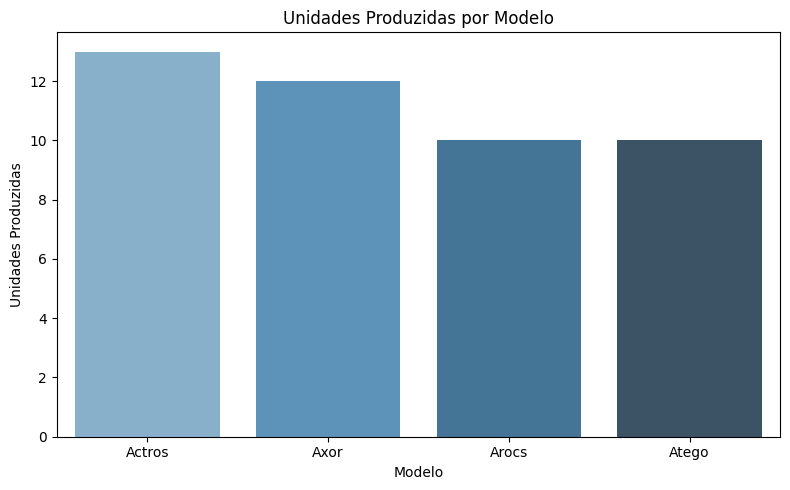

/tmp/ipython-input-3-3722607324.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_result, x="Modelo", y="Tempo Total", palette="Set2")


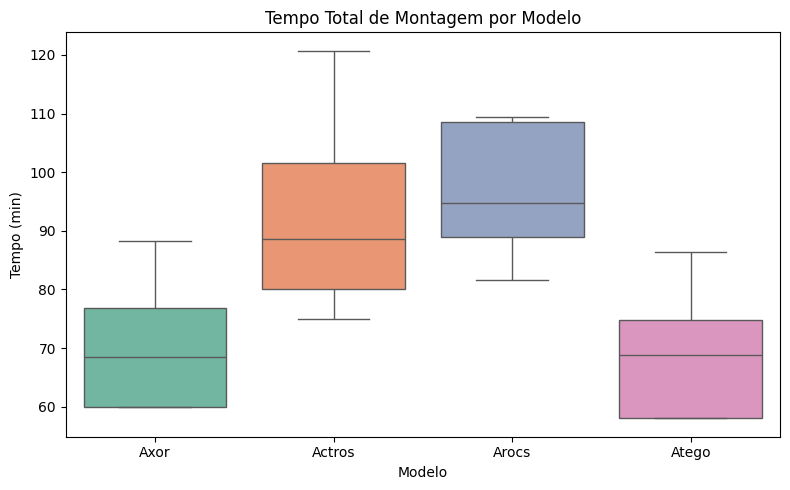

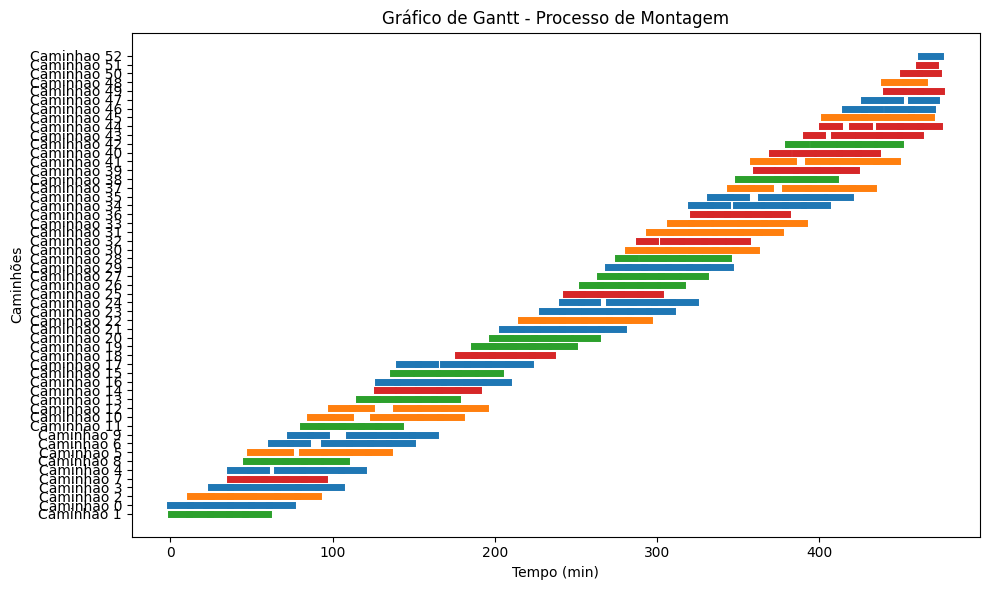

In [ ]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURAÇÕES GERAIS ===
RANDOM_SEED = 42
SIM_TIME = 8 * 60  # 8 horas (em minutos)
INTER_ARRIVAL_TIME = 10  # Média entre chegadas

# === DADOS DOS MODELOS ===
baumusters = {
    "Actros": {"perna": "Perna 1", "tempos": [12, 10, 15, 13, 11, 14]},
    "Arocs": {"perna": "Perna 1", "tempos": [13, 12, 14, 15, 12, 13]},
    "Axor": {"perna": "Perna 2", "tempos": [11, 13, 12, 10, 14]},
    "Atego": {"perna": "Perna 2", "tempos": [10, 11, 13, 12, 12]}
}

# === ARMAZENAMENTO DE RESULTADOS ===
resultados = []
gantt = []

# === PROCESSO DE MONTAGEM ===
def montar_caminhao(env, nome, modelo, estacoes):
    tempos = baumusters[modelo]["tempos"]
    chegada = env.now

    for i, tempo in enumerate(tempos):
        with estacoes[i].request() as req:
            yield req
            start = env.now
            yield env.timeout(tempo)
            end = env.now
            gantt.append({
                "Caminhao": nome,
                "Modelo": modelo,
                "Estacao": f"E{i+1}",
                "Inicio": start,
                "Fim": end
            })

    saida = env.now
    resultados.append({
        "Caminhao": nome,
        "Modelo": modelo,
        "Tempo Total": saida - chegada
    })

# === GERADOR DE CAMINHÕES ===
def gerador_caminhoes(env, pernas_recursos):
    i = 0
    while True:
        modelo = random.choice(list(baumusters.keys()))
        perna = baumusters[modelo]["perna"]
        estacoes = pernas_recursos[perna]
        env.process(montar_caminhao(env, f"Caminhao {i}", modelo, estacoes))
        yield env.timeout(random.expovariate(1.0 / INTER_ARRIVAL_TIME))
        i += 1

# === SIMULAÇÃO ===
def simular():
    random.seed(RANDOM_SEED)
    env = simpy.Environment()

    pernas_recursos = {
        "Perna 1": [simpy.Resource(env, capacity=1) for _ in range(6)],
        "Perna 2": [simpy.Resource(env, capacity=1) for _ in range(5)]
    }

    env.process(gerador_caminhoes(env, pernas_recursos))
    env.run(until=SIM_TIME)

    return pd.DataFrame(resultados), pd.DataFrame(gantt)

# === VISUALIZAÇÃO E ANÁLISE ===
def analisar_e_plotar(df_result, df_gantt):
    # Tabela de unidades por modelo
    unidades = df_result["Modelo"].value_counts().reset_index()
    unidades.columns = ["Modelo", "Unidades Produzidas"]
    print("\nUnidades Produzidas por Modelo:")
    print(unidades)

    # Tempo médio por modelo
    tempos = df_result.groupby("Modelo")["Tempo Total"].describe()
    print("\nTempo Total por Modelo (em minutos):")
    print(tempos)

    # Eficiência: soma dos tempos produtivos / tempo total simulado
    tempo_produzido = df_result["Tempo Total"].sum()
    eficiencia = tempo_produzido / (SIM_TIME)
    print(f"\nEficiência da Linha: {eficiencia:.2%}")

    # --- GRÁFICO 1: Unidades por Modelo ---
    plt.figure(figsize=(8, 5))
    sns.barplot(data=unidades, x="Modelo", y="Unidades Produzidas", palette="Blues_d")
    plt.title("Unidades Produzidas por Modelo")
    plt.tight_layout()
    plt.show()

    # --- GRÁFICO 2: Boxplot dos Tempos por Modelo ---
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_result, x="Modelo", y="Tempo Total", palette="Set2")
    plt.title("Tempo Total de Montagem por Modelo")
    plt.ylabel("Tempo (min)")
    plt.tight_layout()
    plt.show()

    # --- GRÁFICO 3: Gráfico de Gantt ---
    plt.figure(figsize=(10, 6))
    modelos_color = {m: c for m, c in zip(baumusters.keys(), sns.color_palette("tab10"))}
    for i, row in df_gantt.iterrows():
        plt.plot([row["Inicio"], row["Fim"]], [row["Caminhao"]] * 2,
                 color=modelos_color[row["Modelo"]], linewidth=5)
    plt.title("Gráfico de Gantt - Processo de Montagem")
    plt.xlabel("Tempo (min)")
    plt.ylabel("Caminhões")
    plt.tight_layout()
    plt.show()

# === EXECUTAR TUDO ===
df_result, df_gantt = simular()
analisar_e_plotar(df_result, df_gantt)

In [ ]:
%pip install simpy

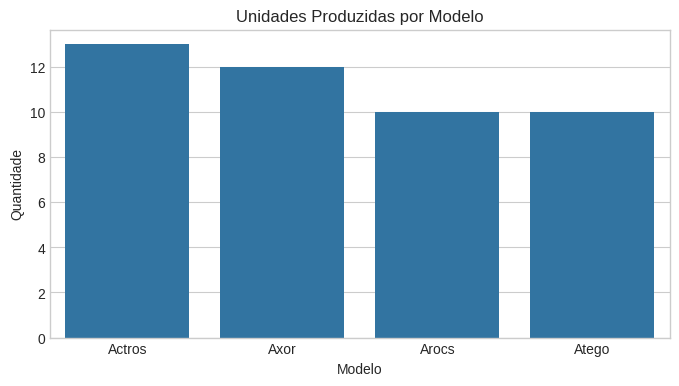

/tmp/ipython-input-7-651798496.py:98: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Modelo', y='Tempo Total', ci=None)


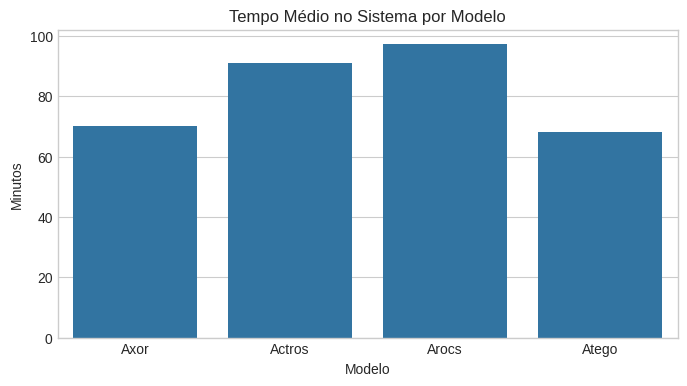

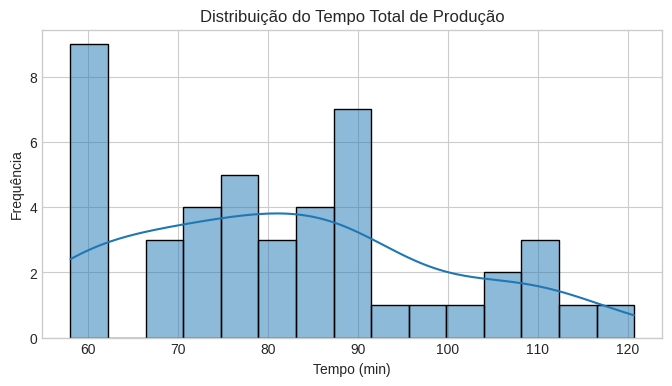


Eficiência por Estação (uso / tempo total):


,Modelo,Estação,Tempo de uso,Eficiência (%)
0,Axor,1,132.0,27.500000
1,Actros,1,192.0,40.000000
2,Actros,2,150.0,31.250000
3,Axor,2,156.0,32.500000
4,Arocs,1,156.0,32.500000
5,Axor,3,144.0,30.000000
6,Actros,3,225.0,46.875000
7,Arocs,2,144.0,30.000000
8,Axor,4,120.0,25.000000
9,Atego,1,130.0,27.083333


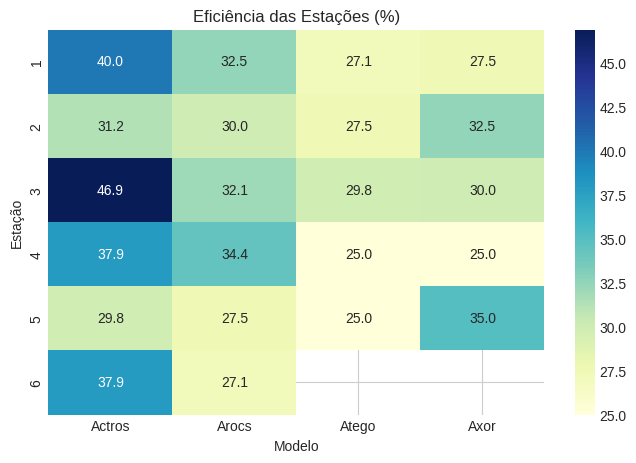

In [ ]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# === CONFIGURAÇÕES GERAIS ===
RANDOM_SEED = 42
SIM_TIME = 8 * 60  # 8 horas em minutos
INTER_ARRIVAL_TIME = 10  # Tempo médio entre chegadas

# === MODELOS / BAUMUSTERS ===
baumusters = {
    "Actros": {
        "perna": "Perna 1",
        "tempos": [12, 10, 15, 13, 11, 14]
    },
    "Arocs": {
        "perna": "Perna 1",
        "tempos": [13, 12, 14, 15, 12, 13]
    },
    "Axor": {
        "perna": "Perna 2",
        "tempos": [11, 13, 12, 10, 14]
    },
    "Atego": {
        "perna": "Perna 2",
        "tempos": [10, 11, 13, 12, 12]
    }
}

# === MÉTRICAS GLOBAIS ===
resultados = []
uso_estacoes = defaultdict(float)

# === PROCESSO DE MONTAGEM ===
def montar_caminhao(env, nome, modelo, estacoes):
    tempos = baumusters[modelo]["tempos"]
    chegada = env.now

    for i, tempo in enumerate(tempos):
        with estacoes[i].request() as req:
            yield req
            start = env.now
            yield env.timeout(tempo)
            fim = env.now
            uso_estacoes[(modelo, i)] += tempo

    saida = env.now
    resultados.append({
        "Caminhão": nome,
        "Modelo": modelo,
        "Tempo Total": saida - chegada
    })

# === GERADOR DE CAMINHÕES ===
def gerador_caminhoes(env, pernas_recursos):
    i = 0
    while True:
        modelo = random.choice(list(baumusters.keys()))
        perna = baumusters[modelo]["perna"]
        estacoes = pernas_recursos[perna]
        env.process(montar_caminhao(env, f"Caminhão {i}", modelo, estacoes))
        yield env.timeout(random.expovariate(1.0 / INTER_ARRIVAL_TIME))
        i += 1

# === SIMULAÇÃO ===
def simular():
    random.seed(RANDOM_SEED)
    env = simpy.Environment()

    # Criar recursos para cada estação
    pernas_recursos = {
        "Perna 1": [simpy.Resource(env, capacity=1) for _ in range(6)],
        "Perna 2": [simpy.Resource(env, capacity=1) for _ in range(5)]
    }

    env.process(gerador_caminhoes(env, pernas_recursos))
    env.run(until=SIM_TIME)

    return pd.DataFrame(resultados), uso_estacoes, pernas_recursos

# === PLOTAGEM ===
def gerar_graficos(df, uso_estacoes, pernas_recursos):
    plt.style.use('seaborn-v0_8-whitegrid')

    # Unidades produzidas por modelo
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x='Modelo', order=df['Modelo'].value_counts().index)
    plt.title("Unidades Produzidas por Modelo")
    plt.ylabel("Quantidade")
    plt.xlabel("Modelo")
    plt.show()

    # Tempo médio no sistema por modelo
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x='Modelo', y='Tempo Total', ci=None)
    plt.title("Tempo Médio no Sistema por Modelo")
    plt.ylabel("Minutos")
    plt.xlabel("Modelo")
    plt.show()

    # Histograma dos tempos totais
    plt.figure(figsize=(8, 4))
    sns.histplot(df['Tempo Total'], bins=15, kde=True)
    plt.title("Distribuição do Tempo Total de Produção")
    plt.xlabel("Tempo (min)")
    plt.ylabel("Frequência")
    plt.show()

    # Eficiência por estação
    print("\nEficiência por Estação (uso / tempo total):")
    estats = []
    for (modelo, estacao), uso in uso_estacoes.items():
        total_sim_time = SIM_TIME
        eficiencia = uso / total_sim_time
        estats.append({
            "Modelo": modelo,
            "Estação": estacao + 1,
            "Tempo de uso": uso,
            "Eficiência (%)": eficiencia * 100
        })

    df_eff = pd.DataFrame(estats)
    display(df_eff)

    # Gráfico de calor da eficiência
    pivot_eff = df_eff.pivot(index="Estação", columns="Modelo", values="Eficiência (%)")
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_eff, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.title("Eficiência das Estações (%)")
    plt.show()

# === EXECUTAR SIMULAÇÃO ===
df_resultado, uso_estacoes, recursos = simular()

# === GERAR TABELAS E GRÁFICOS ===
gerar_graficos(df_resultado, uso_estacoes, recursos)

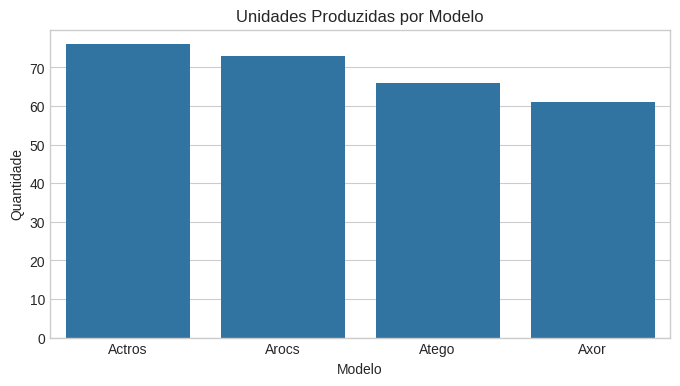

/tmp/ipython-input-4-3328555570.py:117: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_resultado, x='Modelo', y='Tempo Total', ci=None)


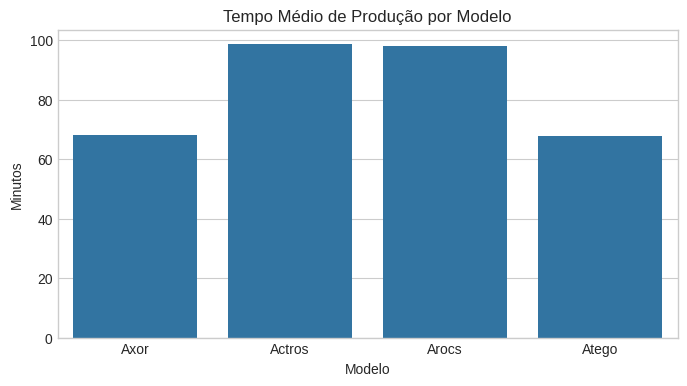

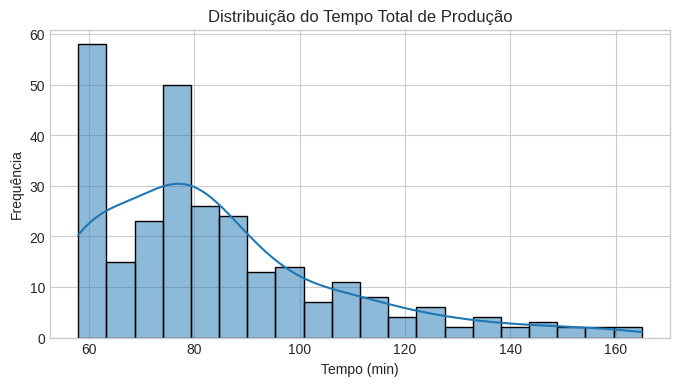

,Perna,Modelo Exemplo,Estação,Eficiência (%),Espera Média (min),Fila Média
0,Perna 1,Actros,1,66.736111,9.399186,1.064935
1,Perna 1,Actros,2,58.263889,0.000000,0.000000
2,Perna 1,Actros,3,76.597222,11.111841,1.177632
3,Perna 1,Actros,4,73.298611,0.313207,0.304636
4,Perna 1,Actros,5,59.861111,0.000000,0.000000
5,Perna 1,Actros,6,69.895833,0.302013,0.295302
6,Perna 2,Axor,1,47.291667,4.341969,0.630769
7,Perna 2,Axor,2,53.576389,2.025048,0.534884
8,Perna 2,Axor,3,55.659722,1.304432,0.468750
9,Perna 2,Axor,4,49.097222,0.000000,0.000000



🚨 Gargalos Identificados:
⚠️  Estação 1 (Perna 1) - Eficiência: 66.7%, Espera: 9.4 min, Fila Média: 1.1
⚠️  Estação 3 (Perna 1) - Eficiência: 76.6%, Espera: 11.1 min, Fila Média: 1.2


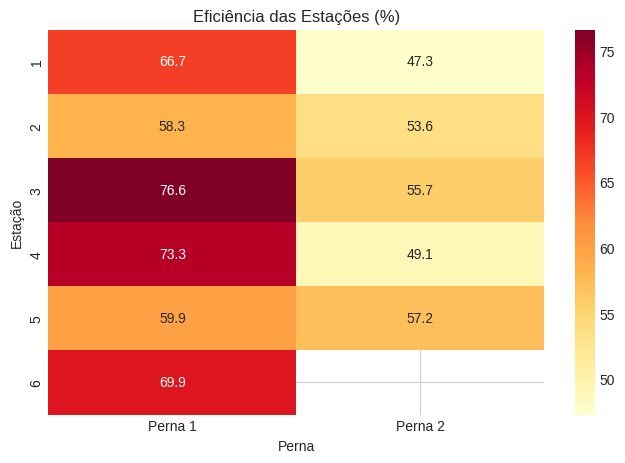

In [ ]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# === CONFIGURAÇÕES GERAIS ===
RANDOM_SEED = 42
N_DIAS = 3
TURNOS_POR_DIA = 2
DURACAO_TURNO = 8 * 60  # minutos
SIM_TIME = N_DIAS * TURNOS_POR_DIA * DURACAO_TURNO
INTER_ARRIVAL_TIME = 10  # Média de 1 caminhão a cada 10 minutos

# === MODELOS / BAUMUSTERS ===
baumusters = {
    "Actros": {
        "perna": "Perna 1",
        "tempos": [12, 10, 15, 13, 11, 14]
    },
    "Arocs": {
        "perna": "Perna 1",
        "tempos": [13, 12, 14, 15, 12, 13]
    },
    "Axor": {
        "perna": "Perna 2",
        "tempos": [11, 13, 12, 10, 14, 10]
    },
    "Atego": {
        "perna": "Perna 2",
        "tempos": [10, 11, 13, 12, 12,11]
    }
}

# === CLASSE MONITORADA DE ESTAÇÃO ===
class EstacaoMonitorada(simpy.Resource):
    def __init__(self, env, capacidade=1):
        super().__init__(env, capacity=capacidade)
        self.env = env
        self.tempo_uso_total = 0
        self.tempo_espera_total = 0
        self.num_atendimentos = 0
        self.filas = []

    def monitorar(self, tempo_exec, tempo_espera):
        self.tempo_uso_total += tempo_exec
        self.tempo_espera_total += tempo_espera
        self.num_atendimentos += 1
        self.filas.append(len(self.queue))

# === RESULTADOS ===
resultados = []
uso_estacoes = defaultdict(float)

# === PROCESSO DE MONTAGEM ===
def montar_caminhao(env, nome, modelo, estacoes):
    tempos = baumusters[modelo]["tempos"]
    chegada = env.now

    for i, tempo in enumerate(tempos):
        start_wait = env.now
        with estacoes[i].request() as req:
            yield req
            espera = env.now - start_wait
            yield env.timeout(tempo)
            estacoes[i].monitorar(tempo, espera)

    saida = env.now
    resultados.append({
        "Caminhão": nome,
        "Modelo": modelo,
        "Tempo Total": saida - chegada
    })

# === GERADOR DE CAMINHÕES ===
def gerador_caminhoes(env, pernas_recursos):
    i = 0
    while True:
        modelo = random.choice(list(baumusters.keys()))
        perna = baumusters[modelo]["perna"]
        estacoes = pernas_recursos[perna]
        env.process(montar_caminhao(env, f"Caminhão {i}", modelo, estacoes))
        yield env.timeout(random.expovariate(1.0 / INTER_ARRIVAL_TIME))
        i += 1

# === SIMULAÇÃO ===
def simular():
    random.seed(RANDOM_SEED)
    env = simpy.Environment()

    # Criar recursos monitorados por perna
    pernas_recursos = {
        "Perna 1": [EstacaoMonitorada(env, capacidade=1) for _ in range(6)],
        "Perna 2": [EstacaoMonitorada(env, capacidade=1) for _ in range(5)]
    }

    env.process(gerador_caminhoes(env, pernas_recursos))
    env.run(until=SIM_TIME)

    return pd.DataFrame(resultados), pernas_recursos

# === ANÁLISE E GRÁFICOS ===
def analisar(df_resultado, pernas_recursos):
    plt.style.use('seaborn-v0_8-whitegrid')

    # 1. Produção por modelo
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_resultado, x='Modelo', order=df_resultado['Modelo'].value_counts().index)
    plt.title("Unidades Produzidas por Modelo")
    plt.ylabel("Quantidade")
    plt.xlabel("Modelo")
    plt.show()

    # 2. Tempo médio por modelo
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_resultado, x='Modelo', y='Tempo Total', ci=None)
    plt.title("Tempo Médio de Produção por Modelo")
    plt.ylabel("Minutos")
    plt.xlabel("Modelo")
    plt.show()

    # 3. Histograma dos tempos totais
    plt.figure(figsize=(8, 4))
    sns.histplot(df_resultado['Tempo Total'], bins=20, kde=True)
    plt.title("Distribuição do Tempo Total de Produção")
    plt.xlabel("Tempo (min)")
    plt.ylabel("Frequência")
    plt.show()

    # 4. Métricas por estação
    estatisticas = []

    for perna, estacoes in pernas_recursos.items():
        for i, est in enumerate(estacoes):
            modelo = None
            for m, props in baumusters.items():
                if props["perna"] == perna and len(props["tempos"]) > i:
                    modelo = m
                    break
            eficiencia = est.tempo_uso_total / SIM_TIME
            espera_media = est.tempo_espera_total / est.num_atendimentos if est.num_atendimentos > 0 else 0
            fila_media = sum(est.filas) / len(est.filas) if est.filas else 0

            estatisticas.append({
                "Perna": perna,
                "Modelo Exemplo": modelo,
                "Estação": i+1,
                "Eficiência (%)": eficiencia * 100,
                "Espera Média (min)": espera_media,
                "Fila Média": fila_media
            })

    df_est = pd.DataFrame(estatisticas)
    display(df_est)

    # 5. Identificação automática de gargalos
    print("\n🚨 Gargalos Identificados:")
    for _, row in df_est.iterrows():
        if row["Eficiência (%)"] > 85 or row["Fila Média"] > 2 or row["Espera Média (min)"] > 5:
            print(f"⚠️  Estação {row['Estação']} ({row['Perna']}) - Eficiência: {row['Eficiência (%)']:.1f}%, "
                  f"Espera: {row['Espera Média (min)']:.1f} min, Fila Média: {row['Fila Média']:.1f}")

    # 6. Heatmap de eficiência
    df_pivot = df_est.pivot(index="Estação", columns="Perna", values="Eficiência (%)")
    plt.figure(figsize=(8, 5))
    sns.heatmap(df_pivot, annot=True, cmap="YlOrRd", fmt=".1f")
    plt.title("Eficiência das Estações (%)")
    plt.show()

# === EXECUTAR SIMULAÇÃO ===
df_resultado, recursos_monitorados = simular()
analisar(df_resultado, recursos_monitorados)

In [ ]:
# Install simpy library
%pip install simpy

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


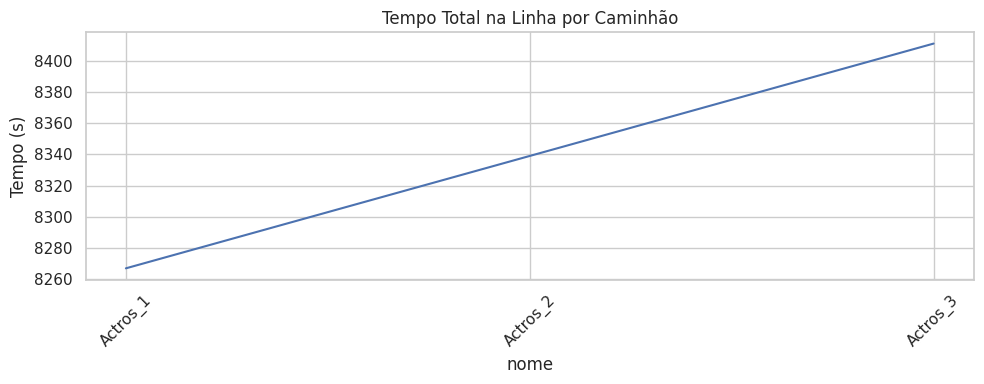

/tmp/ipython-input-7-162321132.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=esperas, x='Posto', y='Espera Média (s)', palette="Blues_d")


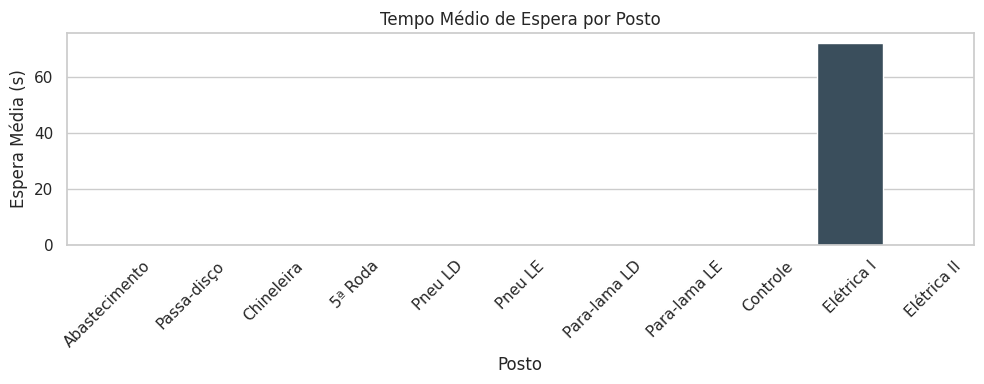

/tmp/ipython-input-7-162321132.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=utilizacao_df, x='Posto', y='Utilização (%)', palette="Greens_d")


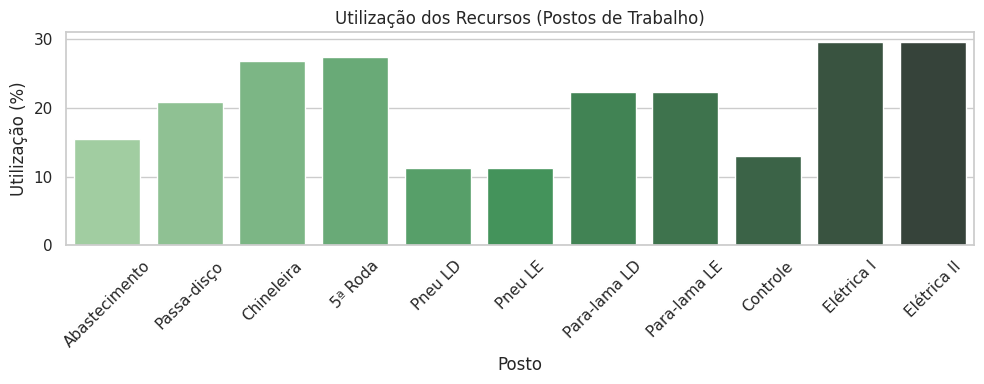


Tabela Resumo dos Caminhões:


,nome,chegada,saida,tempo_total
0,Actros_1,0.0,8267,8267.0
1,Actros_2,990.0,9329,8339.0
2,Actros_3,1980.0,10391,8411.0


In [ ]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------- FUNÇÕES AUXILIARES -----------------------

def format_time(segundos):
    m, s = divmod(segundos, 60)
    h, m = divmod(m, 60)
    return f"{int(h):02d}:{int(m):02d}:{int(s):02d}"

def converter_tempo_para_segundos(tempo_str):
    if pd.isna(tempo_str): return 0
    parts = str(tempo_str).split(':')
    if len(parts) == 3: h, m, s = map(int, parts); return h * 3600 + m * 60 + s
    if len(parts) == 2: m, s = map(int, parts); return m * 60 + s
    return 0

def get_process_times(filepath, modelo):
    df = pd.read_excel(filepath, sheet_name="Yamazumi - Actros", header=5)
    total_row = df[df['Classificação'] == 'Total']

    colunas_postos = df.columns[df.columns.get_loc('Abastecimento'):df.columns.get_loc('Coluna1')]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')

    tempos_formatados = tempos_totais.melt(var_name='Posto', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)

    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Posto).to_dict()

# ----------------------- SIMULAÇÃO -----------------------

def caminhao(env, nome, processos, postos, dados_coletados):
    chegada = env.now
    log = {'nome': nome, 'chegada': chegada}

    for posto_nome, duracao in processos.items():
        recurso = postos[posto_nome]
        with recurso.request() as req:
            inicio_espera = env.now
            yield req
            fim_espera = env.now

            yield env.timeout(duracao)
            fim_processo = env.now

            log[f"{posto_nome}_espera"] = fim_espera - inicio_espera
            log[f"{posto_nome}_execucao"] = duracao

    log['saida'] = env.now
    log['tempo_total'] = env.now - chegada
    dados_coletados.append(log)

def gerador(env, processos, postos, dados_coletados, intervalo_chegada=16.5*60):
    i = 0
    while True:
        i += 1
        env.process(caminhao(env, f"Actros_{i}", processos, postos, dados_coletados))
        yield env.timeout(intervalo_chegada)

# ----------------------- EXECUÇÃO -----------------------

arquivo = '1234_FTP - Grupo 5_Gráficos (Linha 2).xlsx'
processos = get_process_times(arquivo, "Actros")

if processos:
    env = simpy.Environment()
    postos = {nome: simpy.Resource(env, capacity=1) for nome in processos}
    dados = []

    env.process(gerador(env, processos, postos, dados))
    env.run(until=3 * 3600)  # 3 horas de simulação

    df_dados = pd.DataFrame(dados)
    df_dados['tempo_total'] = df_dados['saida'] - df_dados['chegada']

    # ----------------------- GRÁFICOS E TABELAS -----------------------

    sns.set(style='whitegrid')

    # Tempo total por caminhão
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=df_dados, x='nome', y='tempo_total')
    plt.title("Tempo Total na Linha por Caminhão")
    plt.xticks(rotation=45)
    plt.ylabel("Tempo (s)")
    plt.tight_layout()
    plt.show()

    # Tempo de espera médio por posto
    esperas = df_dados.filter(like='_espera').mean().reset_index()
    esperas.columns = ['Posto', 'Espera Média (s)']
    esperas['Posto'] = esperas['Posto'].str.replace('_espera', '')

    plt.figure(figsize=(10, 4))
    sns.barplot(data=esperas, x='Posto', y='Espera Média (s)', palette="Blues_d")
    plt.title("Tempo Médio de Espera por Posto")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Utilização dos recursos
    total_tempo = env.now
    utilizacao = {
        posto: df_dados[f"{posto}_execucao"].sum() / (total_tempo * 1) * 100
        for posto in processos.keys()
    }
    utilizacao_df = pd.DataFrame(utilizacao.items(), columns=['Posto', 'Utilização (%)'])

    plt.figure(figsize=(10, 4))
    sns.barplot(data=utilizacao_df, x='Posto', y='Utilização (%)', palette="Greens_d")
    plt.title("Utilização dos Recursos (Postos de Trabalho)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Tabela final resumida
    print("\nTabela Resumo dos Caminhões:")
    display(df_dados[['nome', 'chegada', 'saida', 'tempo_total']])


In [ ]:
%pip install simpy

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


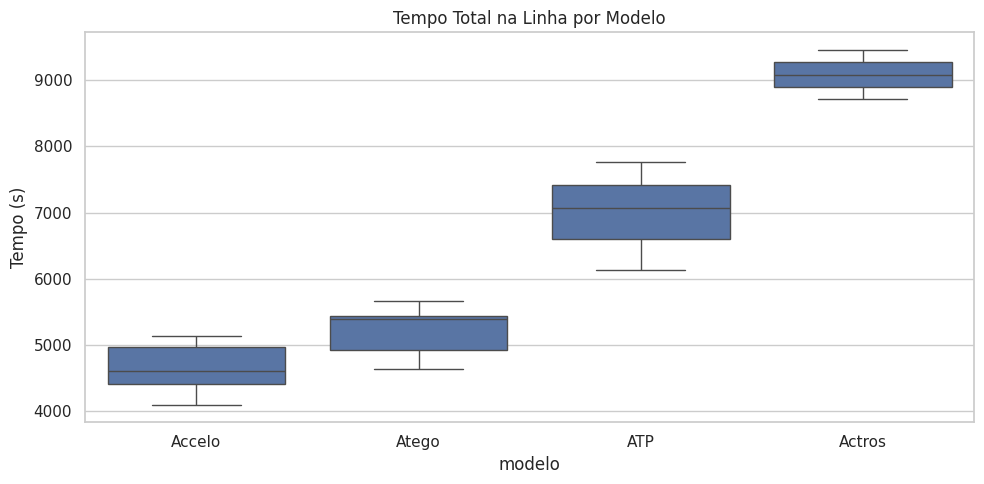

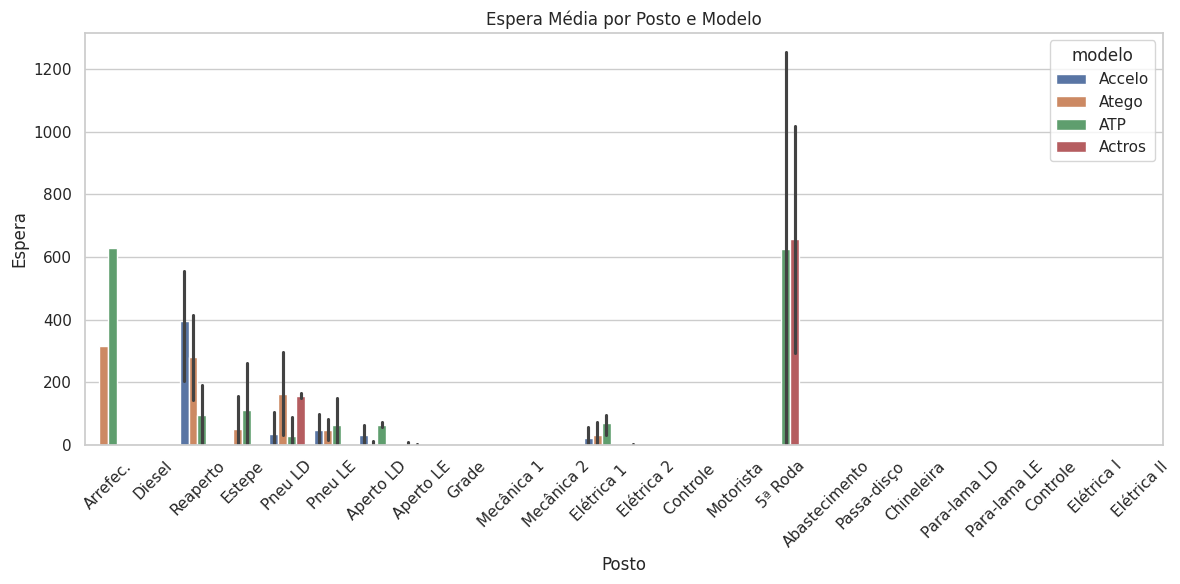

/tmp/ipython-input-9-2824627731.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_util, x="Posto", y="Utilizacao (%)", palette="Greens_d")


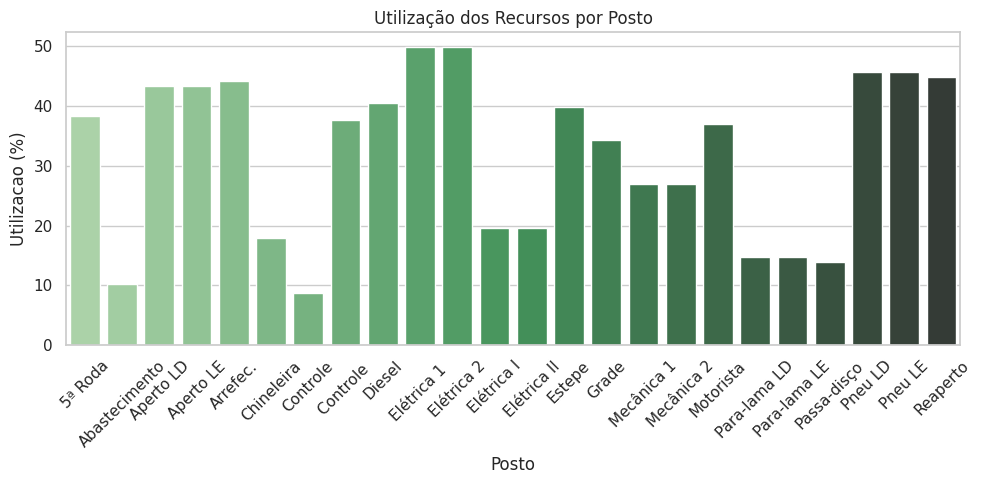

In [ ]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# FUNÇÕES AUXILIARES
# -------------------------------------------------------------------

def converter_tempo_para_segundos(tempo_str):
    if pd.isna(tempo_str): return 0
    parts = str(tempo_str).split(':')
    if len(parts) == 3: h, m, s = map(int, parts); return h * 3600 + m * 60 + s
    if len(parts) == 2: m, s = map(int, parts); return m * 60 + s
    return 0

def extrair_tempos_linha1(filepath, aba):
    df = pd.read_excel(filepath, sheet_name=aba, header=5)
    total_row = df[df['Classificação'] == 'Total']
    colunas_postos = [
        'Arrefec.', 'Diesel', 'Reaperto', '5ª Roda', 'Estepe',
        'Pneu LD', 'Pneu LE', 'Aperto LD', 'Aperto LE', 'Grade',
        'Mecânica 1', 'Mecânica 2', 'Elétrica 1 ', 'Elétrica 2',
        'Controle ', 'Motorista'
    ]
    tempos = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos = tempos.melt(var_name='Posto', value_name='Tempo_str')
    tempos['Tempo_segundos'] = tempos['Tempo_str'].apply(converter_tempo_para_segundos)
    return pd.Series(tempos.Tempo_segundos.values, index=tempos.Posto).to_dict()

def extrair_tempos_linha2(filepath, aba):
    df = pd.read_excel(filepath, sheet_name=aba, header=5)
    total_row = df[df['Classificação'] == 'Total']
    colunas_postos = df.columns[df.columns.get_loc('Abastecimento'):df.columns.get_loc('Coluna1')]
    tempos = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos = tempos.melt(var_name='Posto', value_name='Tempo_str')
    tempos['Tempo_segundos'] = tempos['Tempo_str'].apply(converter_tempo_para_segundos)
    return pd.Series(tempos.Tempo_segundos.values, index=tempos.Posto).to_dict()

# -------------------------------------------------------------------
# CARGA DOS TEMPOS DE CADA MODELO
# -------------------------------------------------------------------

tempos_por_modelo = {
    "Accelo": extrair_tempos_linha1("1234_FTP - Grupo 4_Gráficos (Linha 1).xlsx", "Yamazumi - Accelo"),
    "Atego": extrair_tempos_linha1("1234_FTP - Grupo 4_Gráficos (Linha 1).xlsx", "Yamazumi - Atego"),
    "ATP": extrair_tempos_linha1("1234_FTP - Grupo 4_Gráficos (Linha 1).xlsx", "Yamazumi - ATP"),
    "Actros": extrair_tempos_linha2("1234_FTP - Grupo 5_Gráficos (Linha 2).xlsx", "Yamazumi - Actros")
}

# Consolidar todos os postos
postos_unicos = sorted(set().union(*[set(postos.keys()) for postos in tempos_por_modelo.values()]))

# -------------------------------------------------------------------
# FUNÇÕES DE SIMULAÇÃO
# -------------------------------------------------------------------

def caminhao(env, nome, modelo, processos, postos, dados):
    chegada = env.now
    log = {"nome": nome, "modelo": modelo, "chegada": chegada}

    for posto_nome in processos:
        if posto_nome not in postos:
            continue
        recurso = postos[posto_nome]
        with recurso.request() as req:
            espera_ini = env.now
            yield req
            espera_fim = env.now
            yield env.timeout(processos[posto_nome])
            log[f"{posto_nome}_espera"] = espera_fim - espera_ini
            log[f"{posto_nome}_execucao"] = processos[posto_nome]

    saida = env.now
    log["saida"] = saida
    log["tempo_total"] = saida - chegada
    dados.append(log)

def gerador(env, modelo, processos, postos, dados, takt=16.5*60):
    i = 0
    while True:
        i += 1
        env.process(caminhao(env, f"{modelo}_{i}", modelo, processos, postos, dados))
        yield env.timeout(takt)

# -------------------------------------------------------------------
# EXECUÇÃO DA SIMULAÇÃO
# -------------------------------------------------------------------

env = simpy.Environment()
dados_resultado = []

# Criar recursos compartilhados (linha mista)
postos_ativos = {posto: simpy.Resource(env, capacity=1) for posto in postos_unicos}

# Criar um gerador para cada modelo
for modelo, processos in tempos_por_modelo.items():
    env.process(gerador(env, modelo, processos, postos_ativos, dados_resultado))

# Rodar a simulação por 3 horas
env.run(until=3 * 3600)

# -------------------------------------------------------------------
# ANÁLISE E GRÁFICOS
# -------------------------------------------------------------------

df = pd.DataFrame(dados_resultado)
sns.set(style="whitegrid")

# 1. Tempo total por caminhão
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="modelo", y="tempo_total")
plt.title("Tempo Total na Linha por Modelo")
plt.ylabel("Tempo (s)")
plt.tight_layout()
plt.show()

# 2. Espera média por posto e modelo
espera_cols = [c for c in df.columns if c.endswith("_espera")]
df_espera = df.melt(id_vars=["modelo"], value_vars=espera_cols, var_name="Posto", value_name="Espera")
df_espera["Posto"] = df_espera["Posto"].str.replace("_espera", "")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_espera, x="Posto", y="Espera", hue="modelo")
plt.title("Espera Média por Posto e Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Utilização dos recursos
tempo_total = env.now
utilizacao = []
for posto in postos_unicos:
    soma_exec = df[[col for col in df.columns if col == f"{posto}_execucao"]].sum().values[0] if f"{posto}_execucao" in df.columns else 0
    utilizacao.append({"Posto": posto, "Utilizacao (%)": soma_exec / tempo_total * 100})

df_util = pd.DataFrame(utilizacao)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_util, x="Posto", y="Utilizacao (%)", palette="Greens_d")
plt.title("Utilização dos Recursos por Posto")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
%pip install simpy